In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import multivariate_normal as mvn

import matplotlib

font = {"size": 30}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

def fit_gp(x, y):
    gpr = GPR(
        kernel=RBF(length_scale_bounds="fixed")
        + WhiteKernel(noise_level_bounds="fixed")
    )
    gpr.fit(x, y)
    return gpr



In [3]:

## Create data
grid_size = 20
limits = [0, 10]
x1s = np.linspace(*limits, num=grid_size)
x2s = np.linspace(*limits, num=grid_size)
X1, X2 = np.meshgrid(x1s, x2s)
X = np.vstack([X1.ravel(), X2.ravel()]).T
Y = mvn.rvs(mean=np.zeros(X.shape[0]), cov=RBF()(X))


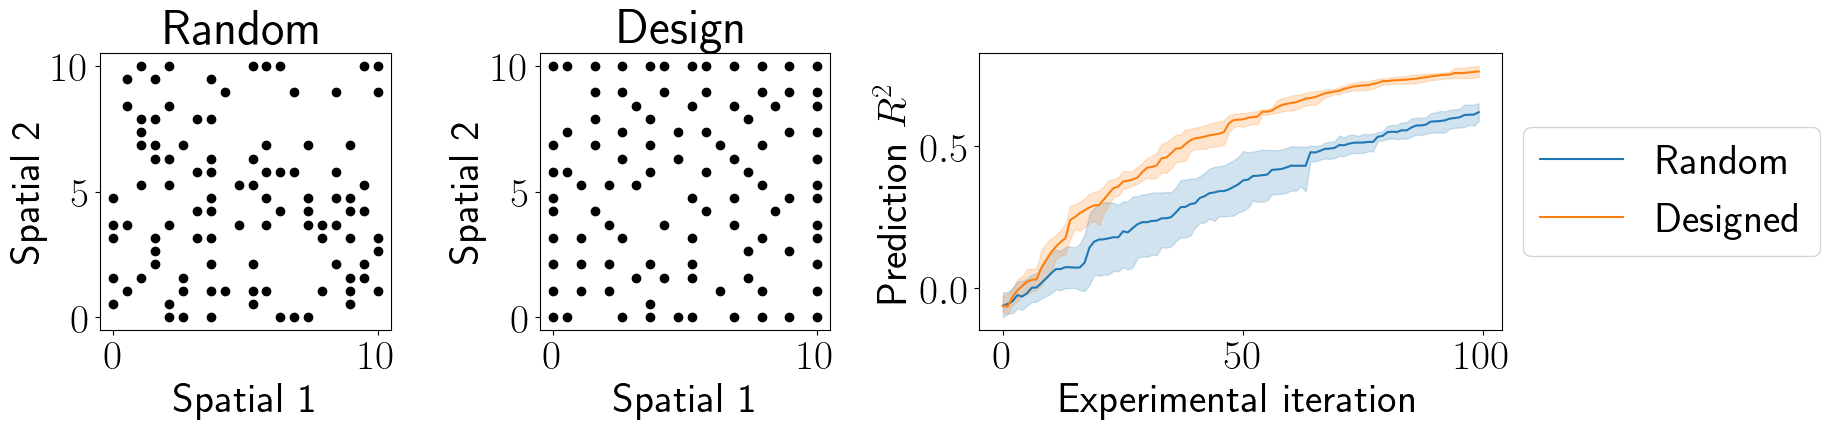

In [4]:

## Run experiment
n_repeats = 5


prior_sample_size = 10
n_iters = 100
results = np.zeros((n_repeats, n_iters))
results_random = np.zeros((n_repeats, n_iters))

for rr in range(n_repeats):

    prior_design_idx = np.random.choice(
        np.arange(X.shape[0]), size=prior_sample_size, replace=False
    )
    prior_designs = X[prior_design_idx]
    prior_observations = Y[prior_design_idx]

    observed_idx = prior_design_idx.copy()

    designs = np.zeros((n_iters, 2))
    observations = np.zeros(n_iters)
    mse_list = np.zeros(n_iters)

    for iternum in range(n_iters):

        # Fit gp
        gpr = fit_gp(X[observed_idx], Y[observed_idx])

        # Take point with highest predictive variance
        preds_mean, preds_stddev = gpr.predict(X, return_std=True)
        curr_design_idx = np.argmax(preds_stddev)
        designs[iternum] = X[curr_design_idx]
        observations[iternum] = Y[curr_design_idx]

        observed_idx = np.append(observed_idx, curr_design_idx)

        # Make predictions of expression
        test_idx = np.setdiff1d(np.arange(X.shape[0]), observed_idx)
        gpr = fit_gp(X[observed_idx], Y[observed_idx])
        preds_mean = gpr.predict(X[test_idx])

        # Compute MSE
        mse = r2_score(Y[test_idx], preds_mean)
        mse_list[iternum] = mse

    results[rr] = mse_list

    # Compare this with choosing locations uniformly at random
    random_design_idx = np.random.choice(
        np.arange(X.shape[0]), size=n_iters, replace=False
    )
    random_designs = X[random_design_idx]
    random_observations = Y[random_design_idx]

    random_mse_list = np.zeros(n_iters)
    observed_idx = prior_design_idx.copy()

    for iternum in range(n_iters):

        observed_idx = np.append(observed_idx, random_design_idx[iternum])

        # Make predictions of expression
        gpr = fit_gp(X[observed_idx], Y[observed_idx])

        test_idx = np.setdiff1d(np.arange(X.shape[0]), observed_idx)
        preds_mean = gpr.predict(X[test_idx])

        # Compute MSE
        mse = r2_score(Y[test_idx], preds_mean)
        random_mse_list[iternum] = mse

    results_random[rr] = random_mse_list

# import ipdb; ipdb.set_trace()
# plt.figure(figsize=(10, 5))
plt.subplots(1, 3, figsize=(19, 5), gridspec_kw={"width_ratios": [5, 5, 9]})

plt.subplot(131)
plt.xlabel("Spatial 1")
plt.ylabel("Spatial 2")
plt.title("Random")
plt.scatter(random_designs[:, 0], random_designs[:, 1], color="black")
plt.subplot(132)
plt.scatter(designs[:, 0], designs[:, 1], color="black")
plt.xlabel("Spatial 1")
plt.ylabel("Spatial 2")
plt.title("Design")
plt.tight_layout()
# plt.savefig("./out/proposed_locations.png")
# plt.show()

# Plot MSE across iterations
# plt.figure(figsize=(9, 5))
plt.subplot(133)
sns.lineplot(
    data=pd.melt(pd.DataFrame(results_random)), x="variable", y="value", label="Random"
)
sns.lineplot(
    data=pd.melt(pd.DataFrame(results)), x="variable", y="value", label="Designed"
)
plt.xlabel("Experimental iteration")
plt.ylabel(r"Prediction $R^2$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("./out/r2_plot.png")
plt.show()
